In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from google.colab import files
uploaded = files.upload()


KeyboardInterrupt: 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!git add .
!git commit -m "feat: DCGAN 코드 업로드"
!git push origin main

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@6b5837c48832.(none)')
Everything up-to-date


In [ ]:
print(uploaded.keys())
# Kaggle API 키를 사용할 수 있도록 이동
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")

# 권한 설정 (필수)
os.chmod("/root/.kaggle/kaggle.json", 600)
print("Kaggle API 키 설정 완료")

dict_keys(['kaggle.json'])
Kaggle API 키 설정 완료


In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# 압축 해제
with zipfile.ZipFile("celeba-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("celeba")

print("데이터셋 압축 해제 완료")

데이터셋 압축 해제 완료


In [ ]:
!ls /content/celeba

img_align_celeba      list_bbox_celeba.csv     list_landmarks_align_celeba.csv
list_attr_celeba.csv  list_eval_partition.csv


## Generator class
### 업샘플링을 통해 처음에는 아주 작은 정보(노이즈)만 있지만, 점점 해상도를 높여서 최종적인 이미지(64x64)를 생성.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Sequential 이용해서 여러 층을 한번에 정의
        self.main = nn.Sequential(
            # 업샘플링을 함. 작은 데이터를 큰 데이터로 늘림. ConvTranspose2d(z값, 변환할 값, 커널 크기, 스트라이드, 패딩)
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), # 숫자가 너무 커지거나 작아지는 것 방지.
            nn.ReLU(True),
            # State size. c x 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State size. c x 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State size. c x 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State size. 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # State size. 3 x 64 x 64
        )

# forward 부분
    def forward(self, input):
        return self.main(input)


## Discriminator

In [ ]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 이미지를 점점 축소하면서 특징을 추출하는 다운샘플링(Conv2d)을 사용
            # Input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. 512 x 4 x 4 최종적으로 하나의 값만 결과를 냄.
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

### 레이어의 초기 값을 정해주는 부분
#### 딥 뉴럴 네트워크에서 gradient vanishing 현상이나 폭발 현상을 막기 위해 conv 레이어의 가중치를 평균값이 0이 되게끔 해주는 것이 일반적.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### generator의 output을 보여주고 저장하는 함수.

In [ ]:
def show_generated_images(images, num_images=64):
    """학습 중 생성된 이미지를 바로 출력하는 함수"""
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Generated Images")

    # 여러 개의 이미지를 그리드 형태로 정렬
    images = vutils.make_grid(images[:num_images], padding=2, normalize=True)
    images = np.transpose(images.cpu().detach(), (1, 2, 0))  # 채널 변환

    plt.imshow(images)
    plt.show()

def save_generated_images(images, num_images, epoch, idx):
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Generated Images")
    images = vutils.make_grid(images[:num_images], padding=2, normalize=True)
    images = np.transpose(images.cpu(), (1, 2, 0))
    # plt.imshow(images)
    fname = './output/image_'+str(epoch)+'_'+str(idx)+'.jpg'
    plt.imsave(fname, images.numpy())
    plt.close()

In [ ]:
# Create the generator and the discriminator
netG = Generator()
netD = Discriminator()

In [ ]:
# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
# 데이터 전처리 설정 (CelebA 이미지를 64x64로 변환)
transform = transforms.Compose([
    transforms.Resize(64),  # 64x64 크기로 조정
    transforms.CenterCrop(64),  # 중앙 부분만 크롭
    transforms.ToTensor(),  # PyTorch 텐서 변환
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # 정규화
])

# CelebA 데이터셋 경로
dataset = datasets.ImageFolder(root="/content/celeba", transform=transform)

# DataLoader 생성 (배치 크기=128)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print("DataLoader 생성 완료!")

DataLoader 생성 완료!


In [ ]:
# 이미지 저장 함수 수정
def save_generated_images(images, num_images, epoch, idx, output_dir="./output"):
    """이미지를 저장하는 함수 (디렉토리가 없으면 생성)"""
    # 저장할 폴더가 없으면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 이미지 저장
    for i in range(num_images):
        vutils.save_image(images[i], f"{output_dir}/image_{epoch}_{idx}_{i}.jpg", normalize=True)

    print(f"{num_images}개의 이미지가 {output_dir}/에 저장됨")

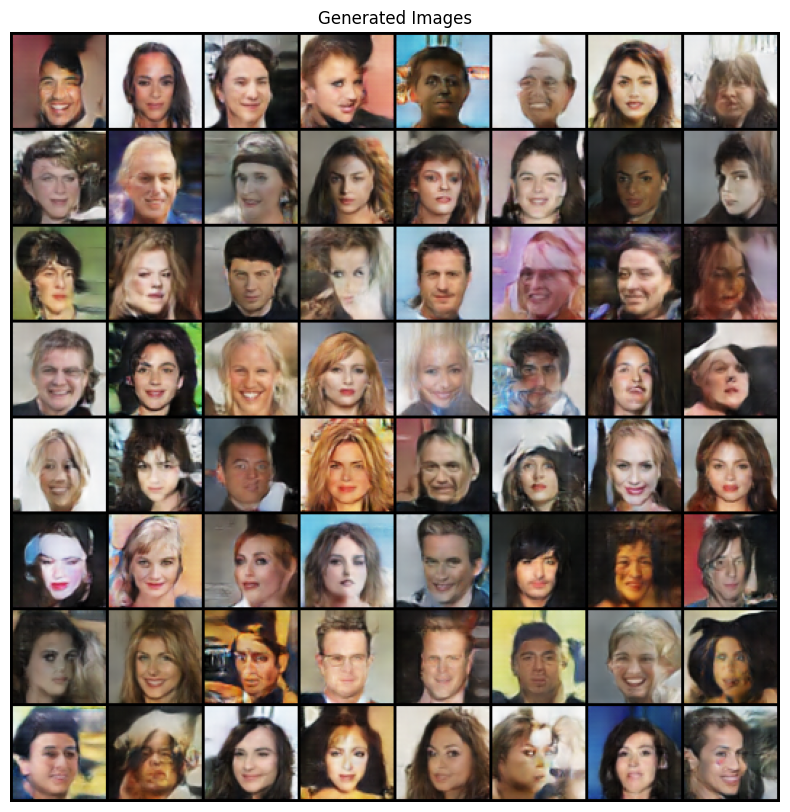

In [ ]:
# Visualization function
fake_images = netG(fixed_noise)
show_generated_images(fake_images)

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        real_label = torch.full((batch_size,), 1, dtype=torch.float, device=device)
        fake_label = torch.full((batch_size,), 0, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = netD(real_data).view(-1)
        errD_real = criterion(output, real_label)
        errD_real.backward()

        # Generate fake image batch with G
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_data = netG(noise)
        output = netD(fake_data.detach()).view(-1)

        # Calculate D's loss on the fake batch
        errD_fake = criterion(output, fake_label)
        errD_fake.backward()

        # Add the gradients from the real and fake batches
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        output = netD(fake_data).view(-1)
        errG = criterion(output, real_label)
        errG.backward()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item()))

            # 이미지 즉시 출력
            show_generated_images(fake_data, num_images=5)

Output hidden; open in https://colab.research.google.com to view.